# **Predicción del Precio de Cierre de BBVA/SAN con Modelos Recurrentes (RNN, LSTM, GRU)**
Este notebook implementa un pipeline completo de predicción financiera para la acción de BBVA y SAN, utilizando redes neuronales recurrentes. Se estructura en cuatro secciones principales:

1. **Preparación de datos:** Carga del dataset, creación de *features* (macroeconómicas y técnicas), escalado, división temporal y generación de ventanas de entrenamiento.

2. **Modelos (RNN, LSTM, GRU):** Implementación y entrenamiento de tres arquitecturas recurrentes para comparar su desempeño en la predicción del precio de cierre (`Close`). Se incluyen métricas de error (MAE, RMSE) y predicciones sobre el conjunto de test.

3. **Gráficas de resultados:** Visualización de la serie real frente a las predicciones de cada modelo y comparación directa entre RNN, LSTM y GRU en el conjunto de test.

4. **Guardado de artefactos:** Exportación de los resultados y artefactos del entrenamiento (checkpoints, CSV de predicciones, figuras comparativas) para posterior análisis y validación.

In [1]:
# Library imports
import os
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import random
import seaborn as sns
from datetime import datetime
import joblib
import json

In [2]:
# Set working directory to project root
os.chdir(Path.cwd().parent)

In [3]:
# Reproducibility settings
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch:", torch.__version__)
print("Device :", str(DEVICE).upper())

PyTorch: 2.9.0+cu130
Device : CUDA


In [4]:
# Path settings
CACHE_DIR   = Path(".cache")
EXO_DIR     = CACHE_DIR / "exogenous"
MODELS_DIR  = Path("models")
REPORTS_DIR = Path("reports")
FIG_DIR     = REPORTS_DIR / "figures"
RES_DIR     = REPORTS_DIR / "results"
for p in [MODELS_DIR, REPORTS_DIR, FIG_DIR, RES_DIR]:
    p.mkdir(parents=True, exist_ok=True)

In [5]:
# Global constants
START_DATE  = "2000-01-01"
END_DATE    = "2025-10-31"
SPLIT_DATE  = "2025-07-01"   # Cutoff date for train/test split
WINDOW_SIZE = 15
BATCH_SIZE  = 64
LR          = 1e-4
EPOCHS      = 400

In [6]:
# Dataset parameters
TARGET_COL  = "Close"
DATA_PATH   = EXO_DIR / "BBVA.MC.csv"  # For SAN use "SAN.MC.csv"
SYMBOL      = "BBVA.MC"                # For SAN use "SAN.MC"

In [7]:
# Pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

## **Carga y selección de features**
**Objetivo:**
Cargar el dataset enriquecido de BBVA y construir el conjunto de *features* que servirán como entrada para los modelos.

**Descripción:**
Se lee el archivo `.csv` desde el directorio cacheado y se filtran las fechas relevantes. Se seleccionan distintos grupos de variables:

* **Eventos exógenos (EVT_)**: indicadores binarios de noticias o sucesos.
* **Variables macroeconómicas** (tipos de interés, inflación, IBEX35, etc.).
* **Datos base OHLCV** y métricas derivadas del análisis exploratorio.
* **Indicadores técnicos simples** como medias móviles y tasas de cambio (ROC).

Finalmente, se limpian los valores nulos y se crea la lista final de columnas que formarán el *input feature set* del modelo.

In [8]:
df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df[(df["Date"] >= START_DATE) & (df["Date"] <= END_DATE)].copy()
df = df.sort_values("Date").reset_index(drop=True)
df.set_index("Date", inplace=True)

In [9]:
df.head()

,Open,High,Low,Close,Volume,ReturnPCT,Vol30,RegimeFlag,EVT_DotCom_Crisis,EVT_Spain_Credit_Boom,EVT_Global_Financial_Crisis,EVT_Euro_Sovereign_Crisis,EVT_Post_Crisis_Recovery,EVT_Brexit_2016,EVT_LateCycle_Weakness,EVT_COVID_Pandemic,EVT_Reopening_Recovery,EVT_Ukraine_War,EVT_ECB_Rate_Hike_Cycle,EVT_Profits_Buybacks_Consolidation,MACRO_ECB_Deposit_Rate,MACRO_Inflation_HICP_EA,MACRO_IBEX35
Date,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,13.690602,13.757854,13.594527,13.623349,8244257,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.9,11610.000000
2000-01-04,13.450416,13.536882,13.219837,13.267874,8522096,-2.609310,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.9,11206.599609
2000-01-05,13.142977,13.210230,12.912399,12.970044,12159826,-2.244743,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.9,10863.099609
2000-01-06,12.970044,12.970044,12.970044,12.970044,0,0.000000,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.9,10982.750000
2000-01-07,13.248659,13.248659,12.998866,13.133370,62261944,1.259258,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.9,11102.400391


In [10]:
# Load original data deleted of features
df_original = pd.read_csv( f".cache/processed/{SYMBOL}.csv", parse_dates=["Date"])
df_original = df_original[(df_original["Date"] >= START_DATE) & (df_original["Date"] <= END_DATE)].copy()
df_original = df_original.sort_values("Date").reset_index(drop=True)
df_original.set_index("Date", inplace=True)
df["Dividends"] = df_original["Dividends"]
df["Dividends"] = df["Dividends"].apply(lambda x: 1 if x > 0 else 0)

df["Adj Close"] = df_original["Adj Close"]

In [11]:
print("Columnas disponibles:", df.columns.tolist())

Columnas disponibles: ['Open', 'High', 'Low', 'Close', 'Volume', 'ReturnPCT', 'Vol30', 'RegimeFlag', 'EVT_DotCom_Crisis', 'EVT_Spain_Credit_Boom', 'EVT_Global_Financial_Crisis', 'EVT_Euro_Sovereign_Crisis', 'EVT_Post_Crisis_Recovery', 'EVT_Brexit_2016', 'EVT_LateCycle_Weakness', 'EVT_COVID_Pandemic', 'EVT_Reopening_Recovery', 'EVT_Ukraine_War', 'EVT_ECB_Rate_Hike_Cycle', 'EVT_Profits_Buybacks_Consolidation', 'MACRO_ECB_Deposit_Rate', 'MACRO_Inflation_HICP_EA', 'MACRO_IBEX35', 'Dividends', 'Adj Close']


In [12]:
evt_cols = [c for c in df.columns if c.startswith("EVT_")] # Event columns
macro_cols = [c for c in ["MACRO_ECB_Deposit_Rate","MACRO_Inflation_HICP_EA","MACRO_IBEX35"] if c in df.columns]
base_cols = [c for c in ["Open","High","Low","Close", "Adj Close", "Volume","ReturnPCT","Vol30","RegimeFlag", "Dividends"] if c in df.columns]

In [13]:
# Technical derived columns
df["MA_10"] = df["Close"].rolling(10).mean()
df["MA_50"] = df["Close"].rolling(50).mean()
df["MA_ratio"] = df["MA_10"] / df["MA_50"] - 1  # Momentum
df["ROC_10"] = (df["Close"] / df["Close"].shift(10) - 1) * 100  # Rate of Change (%)

tech_cols = ["MA_10", "MA_50", "MA_ratio", "ROC_10"]

In [14]:
# Lags for columns
lags = {
    "Close": [1, 3, 5],
    "Vol30": [5],
    "RegimeFlag": [5],
    "MACRO_ECB_Deposit_Rate": [1],
    "MACRO_Inflation_HICP_EA": [1],
    "MACRO_IBEX35": [1, 2],
}

for col, lag_list in lags.items():
    for lag in lag_list:
        new_col = f"{col}_lag{lag}"
        df[new_col] = df[col].shift(lag)

In [15]:
lags_cols = [ c for c in df.columns if "_lag" in c ]

In [16]:
df = df.dropna().copy() # Drop rows with NaN values created by rolling and shifting

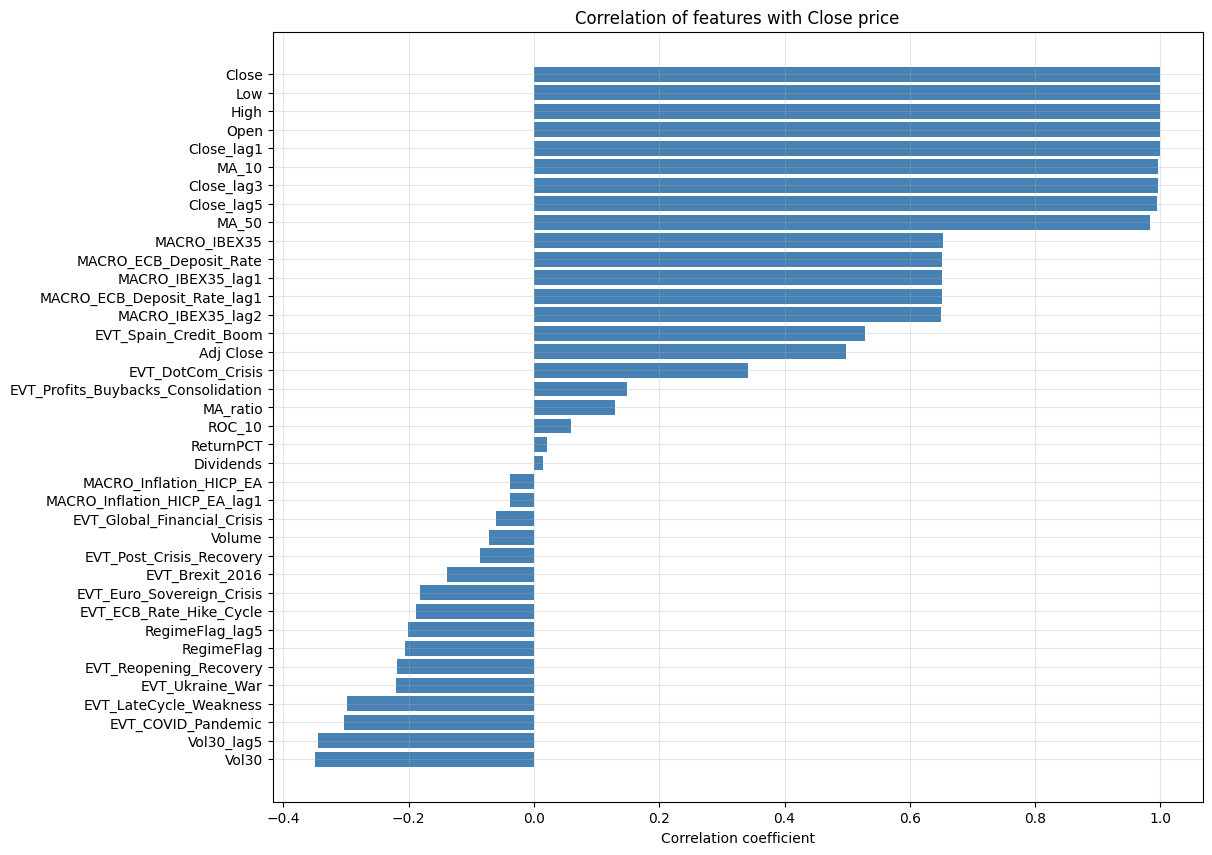

In [17]:
# Correlation matrix
corr_close = df.corr(numeric_only=True)["Close"].sort_values(ascending=False)
corr_df = corr_close.reset_index()
corr_df.columns = ["Variable", "Correlation_with_Close"]

plt.figure(figsize=(12,10))
plt.barh(corr_df["Variable"], corr_df["Correlation_with_Close"], color="steelblue")
plt.title("Correlation of features with Close price")
plt.xlabel("Correlation coefficient")
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.show()

In [18]:
if SYMBOL == "SAN.MC":
    del_cols = ["EVT_Global_Financial_Crisis", "Volume", "ReturnPCT", "Dividends"]
if SYMBOL == "BBVA.MC":
    del_cols = ["ReturnPCT"]

In [19]:
df_1 = df.drop(columns=del_cols, inplace=False)

In [20]:
df_1.head()

,Open,High,Low,Close,Volume,Vol30,RegimeFlag,EVT_DotCom_Crisis,EVT_Spain_Credit_Boom,EVT_Global_Financial_Crisis,EVT_Euro_Sovereign_Crisis,EVT_Post_Crisis_Recovery,EVT_Brexit_2016,EVT_LateCycle_Weakness,EVT_COVID_Pandemic,EVT_Reopening_Recovery,EVT_Ukraine_War,EVT_ECB_Rate_Hike_Cycle,EVT_Profits_Buybacks_Consolidation,MACRO_ECB_Deposit_Rate,MACRO_Inflation_HICP_EA,MACRO_IBEX35,Dividends,Adj Close,MA_10,MA_50,MA_ratio,ROC_10,Close_lag1,Close_lag3,Close_lag5,Vol30_lag5,RegimeFlag_lag5,MACRO_ECB_Deposit_Rate_lag1,MACRO_Inflation_HICP_EA_lag1,MACRO_IBEX35_lag1,MACRO_IBEX35_lag2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-03-10,14.728205,14.833887,14.343907,14.439982,11147673,2.964267,0,1,0,0,0,0,0,0,0,0,0,0,0,2.330645,1.932258,12513.700195,0,4.317359,14.648464,13.484042,0.086356,-4.267511,14.728205,14.680168,14.651346,3.037396,0.0,2.322581,1.929032,12563.200195,12668.299805
2000-03-13,14.430374,14.430374,14.430374,14.430374,0,2.944174,0,1,0,0,0,0,0,0,0,0,0,0,0,2.354839,1.941935,12359.700195,0,4.314486,14.616759,13.500182,0.082708,-2.149842,14.439982,14.795457,14.689775,3.038401,0.0,2.330645,1.932258,12513.700195,12563.200195
2000-03-14,14.199796,14.199796,13.950002,14.199796,6665918,2.962442,0,1,0,0,0,0,0,0,0,0,0,0,0,2.362903,1.945161,12555.799805,0,4.245546,14.586015,13.518821,0.078941,-2.119204,14.430374,14.728205,14.680168,3.029758,0.0,2.354839,1.941935,12359.700195,12513.700195
2000-03-15,14.170974,14.170974,13.959610,13.959610,5468445,2.983967,0,1,0,0,0,0,0,0,0,0,0,0,0,2.370968,1.948387,12279.500000,0,4.173733,14.516842,13.538612,0.072255,-4.721315,14.199796,14.439982,14.795457,2.995614,0.0,2.362903,1.945161,12555.799805,12359.700195
2000-03-16,14.180581,14.699383,14.065292,14.670560,12188949,3.108340,0,1,0,0,0,0,0,0,0,0,0,0,0,2.379032,1.951613,12260.900391,0,4.386295,14.524527,13.572622,0.070134,0.526655,13.959610,14.430374,14.728205,2.934560,0.0,2.370968,1.948387,12279.500000,12555.799805


In [21]:
features = base_cols + evt_cols + macro_cols + tech_cols + lags_cols
features = [c for c in features if c in df_1.columns]
df_1 = df_1.dropna(subset=features + [TARGET_COL]).copy()

print(f"Total features seleccionadas: {len(features)}")

Total features seleccionadas: 37


## **Split temporal, escalado y ventanas**

**Objetivo:**
Preparar los datos para el entrenamiento secuencial de los modelos.

**Descripción:**
Se realiza una separación temporal de los datos en *train* y *test* según la fecha definida. Las variables continuas se escalan con `MinMaxScaler`, manteniendo sin escalar las columnas binarias.
Luego, se generan las **ventanas deslizantes** de longitud `WINDOW_SIZE`, donde cada muestra contiene las observaciones de los últimos *n* días y el valor objetivo a predecir (el *Close* del día siguiente).
Finalmente, se construyen los *DataLoaders* para PyTorch, listos para el entrenamiento por lotes.

In [22]:
# Split data into train and test sets
train = df_1[df_1.index < SPLIT_DATE].copy()
test  = df_1[df_1.index >= SPLIT_DATE].copy()

In [23]:
print(f"Train: {train.index.min().date()} to {train.index.max().date()} ({len(train)} rows)")
print(f"Test : {test.index.min().date()} to {test.index.max().date()} ({len(test)} rows)")

Train: 2000-03-10 to 2025-06-30 (6497 rows)
Test : 2025-07-01 to 2025-10-31 (89 rows)


In [24]:
# Binary columns (not to scale): all EVT_ + RegimeFlag + Dividends + RegimeFlag_lag5
binary_cols = [c for c in features if c.startswith("EVT_")] +(["RegimeFlag"] if "RegimeFlag" in features else []) + ( ["Dividends"] if "Dividends" in features else []) + ( ["RegimeFlag_lag5"] if "RegimeFlag_lag5" in features else [])

# Continous to scale: all other numeric including TARGET (for training)
cont_cols = [c for c in features + [TARGET_COL] if c not in binary_cols]

In [25]:
train_scaled = train.copy()
test_scaled  = test.copy()

In [26]:
scaler_X = MinMaxScaler()
scaler_X.fit(train[features])  # Apply fit only on training data

train_scaled[features] = scaler_X.transform(train[features])
test_scaled[features]  = scaler_X.transform(test[features])

In [27]:
scaler_y = MinMaxScaler()
scaler_y.fit(train[[TARGET_COL]])
train_scaled[TARGET_COL] = scaler_y.transform(train[[TARGET_COL]])
test_scaled[TARGET_COL]  = scaler_y.transform(test[[TARGET_COL]])

### **Creación de secuencias temporales para modelos recurrentes**
**Objetivo:**
Transformar los datos históricos en **ventanas temporales** que puedan ser entendidas por modelos secuenciales como **RNN, LSTM o GRU**.

**Descripción:**
En esta sección se define y ejecuta la función, cuya finalidad es **convertir la serie temporal original en múltiples fragmentos consecutivos (ventanas)**.
Cada ventana contiene un número fijo de observaciones pasadas (`WINDOW_SIZE`) que el modelo usará como entrada para **predecir el valor del día siguiente**.

Esta estructura es esencial para las redes recurrentes, ya que les permite aprender **patrones de dependencia temporal** dentro de los datos históricos.
El resultado de la función son tres conjuntos sincronizados:

* `X`: las secuencias de entrada (ventanas de tamaño fijo),
* `y`: el valor objetivo a predecir,
* `dates`: las fechas asociadas a cada muestra.

Con estos elementos, los datos quedan listos para alimentar las arquitecturas **RNN, LSTM y GRU**, facilitando el entrenamiento y la evaluación de los modelos.

In [28]:
# Function to create sequences for RNN/LSTM/GRU models
def make_sequences(dataframe, feature_cols, target_col, window):
    '''
    Creates sequences of data for RNN/LSTM/GRU models.
    Arguments:
        - dataframe: pd.DataFrame with the data
        - feature_cols: list of feature column names
        - target_col: name of the target column
        - window: size of the rolling window (number of time steps)
    Returns:
        - X: np.array of shape (num_samples, window, num_features)
        - y: np.array of shape (num_samples, 1)
        - dates: np.array of shape (num_samples,) with the corresponding dates
    '''
    X, y, dates = [], [], []
    vals_X = dataframe[feature_cols].values # Feature values
    vals_y = dataframe[target_col].values # Target values
    idx    = dataframe.index # Index values: Date

    for i in range(window, len(dataframe)):
        X.append(vals_X[i-window:i, :]) # Sequence of features: WINDOW x num_features
        y.append(vals_y[i]) # Target value at time i
        dates.append(idx[i]) # Date at time i

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32).reshape(-1, 1)
    dates = np.array(dates)
    return X, y, dates

In [29]:
X_train, y_train, _          = make_sequences(train_scaled, features, TARGET_COL, WINDOW_SIZE)
X_test,  y_test,  dates_test = make_sequences(test_scaled,  features, TARGET_COL, WINDOW_SIZE)

In [30]:
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test :", X_test.shape,  "| y_test :", y_test.shape)

X_train: (6482, 15, 37) | y_train: (6482, 1)
X_test : (74, 15, 37) | y_test : (74, 1)


In [31]:
class TimeSeriesDS(Dataset):
    '''
    PyTorch Dataset for time series data.
    '''
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

In [32]:
train_loader = DataLoader(TimeSeriesDS(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(TimeSeriesDS(X_test,  y_test),  batch_size=BATCH_SIZE, shuffle=False)

In [33]:
N_FEATURES = X_train.shape[-1]
N_FEATURES

37

## **Definición de modelos (RNN, LSTM, GRU)**

**Objetivo:**
Definir las arquitecturas neuronales recurrentes que se van a comparar.

**Descripción:**
Se implementan tres clases PyTorch independientes:

* **RNN** (Recurrent Neural Network) básica.
* **LSTM** (Long Short-Term Memory), capaz de capturar dependencias de largo plazo.
* **GRU** (Gated Recurrent Unit), una variante más ligera que la LSTM.

Cada modelo recibe una secuencia de vectores de entrada y devuelve una predicción del precio de cierre.

In [34]:
class RNNModel(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1, dropout=0.2):
        """
        Simple RNN with configurable parameters.
        """
        super().__init__()
        self.rnn = nn.RNN(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out[:, -1, :])  # Just the last time step
        return self.fc(out)

In [35]:
class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1, dropout=0.2):
        """
        LSTM with Dropout between layers and a final linear layer.
        """
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

In [36]:
class GRUModel(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1, dropout=0.2):
        """
        GRU with configurable Dropout.
        """
        super().__init__()
        self.gru = nn.GRU(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

In [37]:
HIDDEN_SIZE = 64
NUM_LAYERS  = 2
DROPOUT     = 0.2

rnn_model  = RNNModel(N_FEATURES, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
lstm_model = LSTMModel(N_FEATURES, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
gru_model  = GRUModel(N_FEATURES, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)

print(rnn_model)
print(lstm_model)
print(gru_model)

RNNModel(
  (rnn): RNN(37, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
LSTMModel(
  (lstm): LSTM(37, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
GRUModel(
  (gru): GRU(37, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## **Entrenamiento genérico y evaluación**

**Objetivo:**
Definir el bucle de entrenamiento, la inferencia y las métricas de evaluación.

**Descripción:**
Se construye una función genérica de entrenamiento con `MSELoss` y optimizador `Adam`.
Durante las épocas de entrenamiento, el modelo aprende a minimizar el error cuadrático medio entre la predicción y el valor real.
También se incluyen funciones auxiliares para realizar inferencia en el conjunto test (predicciones escaladas) y para calcular las métricas principales: **RMSE**, **MAE** y **R²**, todas en escala real (€).

In [38]:
criterion = nn.MSELoss()

def train_loop(model, train_loader, n_epochs=200, lr=1e-3, device=DEVICE, modelo_id="MODEL"):
    """
    Bucle de entrenamiento con métrica por época en escala normalizada (igual que tu ejemplo):
    - Loss (MSE)
    - RMSE (train)
    - MAE  (train)
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        train_losses = []
        y_true_epoch = []
        y_pred_epoch = []

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Acumuladores
            train_losses.append(loss.item())
            y_true_epoch.extend(y_batch.detach().cpu().numpy())
            y_pred_epoch.extend(y_pred.detach().cpu().numpy())

        # Métricas de la época (en escala normalizada)
        train_rmse = np.sqrt(mean_squared_error(y_true_epoch, y_pred_epoch))
        train_mae  = mean_absolute_error(y_true_epoch, y_pred_epoch)
        mean_loss  = np.mean(train_losses)

        print(f"{modelo_id} | Epoch {epoch+1:03d}/{n_epochs} "
              f"- Loss: {mean_loss:.6f} "
              f"- RMSE: {train_rmse:.5f} "
              f"- MAE: {train_mae:.5f}")

    return model


@torch.no_grad()
def predict_scaled(model, X, device=DEVICE):
    """Devuelve predicciones en escala NORMALIZADA (como sale del modelo)."""
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    yhat = model(X_t).cpu().numpy().reshape(-1, 1)
    return yhat


def inverse_target(y_scaled):
    """Convierte (n,1) desde escala normalizada → euros usando scaler_y (definido en Fase 2)."""
    return scaler_y.inverse_transform(y_scaled)


def test_metrics_real(y_test_scaled, yhat_scaled, return_series=False):
    """
    Calcula métricas en escala REAL (€):
      - y_test_scaled, yhat_scaled: (n,1) en escala normalizada
    """
    y_true_real = inverse_target(y_test_scaled)
    y_pred_real = inverse_target(yhat_scaled)

    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae  = mean_absolute_error(y_true_real, y_pred_real)
    r2   = r2_score(y_true_real, y_pred_real)

    out = {"RMSE": float(rmse), "MAE": float(mae), "R2": float(r2)}
    if return_series:
        return out, y_true_real, y_pred_real
    return out

## **Entrenamiento de los modelos RNN, LSTM y GRU**

**Objetivo:**
Entrenar los tres modelos sobre los mismos datos y comparar su rendimiento cuantitativo.

**Descripción:**
Cada red (RNN, LSTM, GRU) se entrena de forma independiente con los hiperparámetros definidos (capas ocultas, *learning rate*, épocas).
Tras el entrenamiento, se generan las predicciones sobre el conjunto de test, se aplica la inversa del escalado y se calculan las métricas reales para cada modelo.
De esta forma, se obtiene una primera comparación objetiva de desempeño.

In [39]:
rnn_model  = RNNModel (N_FEATURES, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT)
rnn_model  = train_loop(rnn_model,  train_loader, n_epochs=EPOCHS, lr=LR, device=DEVICE, modelo_id="RNN ")
yhat_rnn_s  = predict_scaled(rnn_model,  X_test, device=DEVICE)
m_rnn,  y_test_real, yhat_rnn_real  = test_metrics_real(y_test, yhat_rnn_s,  return_series=True)

RNN  | Epoch 001/400 - Loss: 0.035389 - RMSE: 0.18847 - MAE: 0.13550
RNN  | Epoch 002/400 - Loss: 0.007013 - RMSE: 0.08365 - MAE: 0.06469
RNN  | Epoch 003/400 - Loss: 0.005006 - RMSE: 0.07080 - MAE: 0.05468
RNN  | Epoch 004/400 - Loss: 0.004075 - RMSE: 0.06388 - MAE: 0.04949
RNN  | Epoch 005/400 - Loss: 0.003523 - RMSE: 0.05920 - MAE: 0.04563
RNN  | Epoch 006/400 - Loss: 0.003174 - RMSE: 0.05629 - MAE: 0.04351
RNN  | Epoch 007/400 - Loss: 0.003005 - RMSE: 0.05487 - MAE: 0.04218
RNN  | Epoch 008/400 - Loss: 0.002742 - RMSE: 0.05239 - MAE: 0.04013
RNN  | Epoch 009/400 - Loss: 0.002582 - RMSE: 0.05081 - MAE: 0.03885
RNN  | Epoch 010/400 - Loss: 0.002527 - RMSE: 0.05020 - MAE: 0.03837
RNN  | Epoch 011/400 - Loss: 0.002456 - RMSE: 0.04933 - MAE: 0.03725
RNN  | Epoch 012/400 - Loss: 0.002206 - RMSE: 0.04700 - MAE: 0.03591
RNN  | Epoch 013/400 - Loss: 0.002154 - RMSE: 0.04644 - MAE: 0.03557
RNN  | Epoch 014/400 - Loss: 0.002063 - RMSE: 0.04545 - MAE: 0.03436
RNN  | Epoch 015/400 - Loss: 0.001

In [40]:
gru_model  = GRUModel (N_FEATURES, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT)
gru_model  = train_loop(gru_model,  train_loader, n_epochs=EPOCHS, lr=LR, device=DEVICE, modelo_id="GRU ")
yhat_gru_s  = predict_scaled(gru_model,  X_test, device=DEVICE)
m_gru,  _,           yhat_gru_real  = test_metrics_real(y_test, yhat_gru_s,  return_series=True)

GRU  | Epoch 001/400 - Loss: 0.044180 - RMSE: 0.21084 - MAE: 0.14528
GRU  | Epoch 002/400 - Loss: 0.005277 - RMSE: 0.07279 - MAE: 0.05592
GRU  | Epoch 003/400 - Loss: 0.004010 - RMSE: 0.06332 - MAE: 0.04864
GRU  | Epoch 004/400 - Loss: 0.003472 - RMSE: 0.05885 - MAE: 0.04486
GRU  | Epoch 005/400 - Loss: 0.003185 - RMSE: 0.05651 - MAE: 0.04269
GRU  | Epoch 006/400 - Loss: 0.002858 - RMSE: 0.05348 - MAE: 0.04036
GRU  | Epoch 007/400 - Loss: 0.002720 - RMSE: 0.05225 - MAE: 0.03944
GRU  | Epoch 008/400 - Loss: 0.002694 - RMSE: 0.05188 - MAE: 0.03920
GRU  | Epoch 009/400 - Loss: 0.002443 - RMSE: 0.04941 - MAE: 0.03750
GRU  | Epoch 010/400 - Loss: 0.002367 - RMSE: 0.04857 - MAE: 0.03634
GRU  | Epoch 011/400 - Loss: 0.002147 - RMSE: 0.04634 - MAE: 0.03490
GRU  | Epoch 012/400 - Loss: 0.002005 - RMSE: 0.04482 - MAE: 0.03373
GRU  | Epoch 013/400 - Loss: 0.001974 - RMSE: 0.04429 - MAE: 0.03355
GRU  | Epoch 014/400 - Loss: 0.001932 - RMSE: 0.04394 - MAE: 0.03287
GRU  | Epoch 015/400 - Loss: 0.001

In [41]:
lstm_model = LSTMModel(N_FEATURES, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT)
lstm_model = train_loop(lstm_model, train_loader, n_epochs=EPOCHS, lr=LR, device=DEVICE, modelo_id="LSTM")
yhat_lstm_s = predict_scaled(lstm_model, X_test, device=DEVICE)
m_lstm, _,           yhat_lstm_real = test_metrics_real(y_test, yhat_lstm_s, return_series=True)

LSTM | Epoch 001/400 - Loss: 0.078500 - RMSE: 0.28098 - MAE: 0.21173
LSTM | Epoch 002/400 - Loss: 0.005735 - RMSE: 0.07585 - MAE: 0.05972
LSTM | Epoch 003/400 - Loss: 0.003223 - RMSE: 0.05675 - MAE: 0.04348
LSTM | Epoch 004/400 - Loss: 0.002886 - RMSE: 0.05369 - MAE: 0.04083
LSTM | Epoch 005/400 - Loss: 0.002660 - RMSE: 0.05124 - MAE: 0.03868
LSTM | Epoch 006/400 - Loss: 0.002443 - RMSE: 0.04951 - MAE: 0.03762
LSTM | Epoch 007/400 - Loss: 0.002392 - RMSE: 0.04899 - MAE: 0.03675
LSTM | Epoch 008/400 - Loss: 0.002207 - RMSE: 0.04705 - MAE: 0.03530
LSTM | Epoch 009/400 - Loss: 0.002084 - RMSE: 0.04575 - MAE: 0.03437
LSTM | Epoch 010/400 - Loss: 0.002106 - RMSE: 0.04589 - MAE: 0.03409
LSTM | Epoch 011/400 - Loss: 0.002019 - RMSE: 0.04502 - MAE: 0.03354
LSTM | Epoch 012/400 - Loss: 0.001899 - RMSE: 0.04363 - MAE: 0.03285
LSTM | Epoch 013/400 - Loss: 0.001852 - RMSE: 0.04308 - MAE: 0.03219
LSTM | Epoch 014/400 - Loss: 0.001827 - RMSE: 0.04251 - MAE: 0.03160
LSTM | Epoch 015/400 - Loss: 0.001

## **Gráficas individuales por modelo**

**Objetivo:**
Visualizar el ajuste de cada modelo sobre el conjunto de test.

**Descripción:**
Se genera una gráfica por modelo (RNN, LSTM, GRU) mostrando las curvas de precios reales y predichos.
Esto permite observar visualmente la capacidad de cada red para seguir la tendencia del precio y detectar posibles desfases o sobreajustes.

In [42]:
def _colvec(a):
    '''
    Ensures a is a column vector (n,1).
    Arguments:
        - a: array-like (n,) or (n,1)
    Returns:
        - np.array of shape (n,1)
    '''
    a = np.asarray(a)
    return a.reshape(-1, 1) if a.ndim == 1 else a

In [43]:
def to_real(y_scaled):
    """Descale (n,) or (n,1) -> (n,1) in € using scaler_y.
    Arguments:
        - y_scaled: (n,) or (n,1) array-like in normalized scale
    Returns:
        - (n,1) np.array in real € scale
    """
    return scaler_y.inverse_transform(_colvec(y_scaled))

In [44]:
def compute_metrics_real(y_true_real, y_pred_real):
    """
    Compute regression metrics in real scale (€).
    Arguments:
        - y_true_real: (n,) or (n,1) array-like in real € scale
        - y_pred_real: (n,) or (n,1) array-like in real € scale
    Returns:
        - dict with RMSE, MAE, R2
    """
    y_true_real = np.asarray(y_true_real).ravel()
    y_pred_real = np.asarray(y_pred_real).ravel()
    rmse = mean_squared_error(y_true_real, y_pred_real)
    mae  = mean_absolute_error(y_true_real, y_pred_real)
    r2   = r2_score(y_true_real, y_pred_real)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

def plot_error_fill(dates, y_true_real, y_pred_real, model_label="RNN"):
    """
    Plot real vs predicted with error fill.
    Arguments:
        - dates: (n,) array-like of dates
        - y_true_real: (n,) or (n,1) array-like in real
        - y_pred_real: (n,) or (n,1) array-like in real
        - model_label: str, label for the model in the plot
    Returns:
        - None
    """
    y_true_real = np.asarray(y_true_real).ravel()
    y_pred_real = np.asarray(y_pred_real).ravel()

    fig, ax = plt.subplots(figsize=(9, 5))

    ax.plot(dates, y_true_real, label="Real Price", color="#1f77b4", linewidth=2)
    ax.plot(dates, y_pred_real, label=f"Prediction {model_label}", color="#66b3ff", linewidth=2, linestyle="--")
    ax.fill_between(dates, y_true_real, y_pred_real, color="#cce5ff", alpha=0.4, label="Difference")
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")
    y_min = min(y_true_real.min(), y_pred_real.min()) - 1
    y_max = max(y_true_real.max(), y_pred_real.max()) + 1
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.2f} €"))
    ax.set_title(f"{SYMBOL} — {model_label} (TEST)", fontsize=13, fontweight="bold")
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel("Close Price (€)", fontsize=10)
    ax.legend(frameon=False, fontsize=10)
    ax.tick_params(axis="both", labelsize=9)
    ax.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

In [45]:
try:
    y_test_real
    yhat_rnn_real
    yhat_lstm_real
    yhat_gru_real
except NameError:
    # If not defined, compute them from scaled versions
    y_test_real    = to_real(y_test)
    yhat_rnn_real  = to_real(yhat_rnn_s)
    yhat_lstm_real = to_real(yhat_lstm_s)
    yhat_gru_real  = to_real(yhat_gru_s)

In [46]:
# Flatten for plotting
y_test_real    = y_test_real.ravel()
yhat_rnn_real  = yhat_rnn_real.ravel()
yhat_lstm_real = yhat_lstm_real.ravel()
yhat_gru_real  = yhat_gru_real.ravel()

In [47]:
metrics_rnn  = compute_metrics_real(y_test_real, yhat_rnn_real)
metrics_lstm = compute_metrics_real(y_test_real, yhat_lstm_real)
metrics_gru  = compute_metrics_real(y_test_real, yhat_gru_real)
metrics_df = pd.DataFrame([metrics_rnn, metrics_lstm, metrics_gru], index=["RNN", "LSTM", "GRU"])

print("\nMétricas finales en TEST (escala real, €):")
print(f"RNN  → RMSE: {metrics_rnn['RMSE']:.4f}  | MAE: {metrics_rnn['MAE']:.4f}  | R²: {metrics_rnn['R2']:.4f}")
print(f"LSTM → RMSE: {metrics_lstm['RMSE']:.4f} | MAE: {metrics_lstm['MAE']:.4f} | R²: {metrics_lstm['R2']:.4f}")
print(f"GRU  → RMSE: {metrics_gru['RMSE']:.4f}  | MAE: {metrics_gru['MAE']:.4f}  | R²: {metrics_gru['R2']:.4f}")


Métricas finales en TEST (escala real, €):
RNN  → RMSE: 0.0968  | MAE: 0.2499  | R²: 0.9161
LSTM → RMSE: 0.1429 | MAE: 0.2959 | R²: 0.8762
GRU  → RMSE: 0.0816  | MAE: 0.2128  | R²: 0.9293


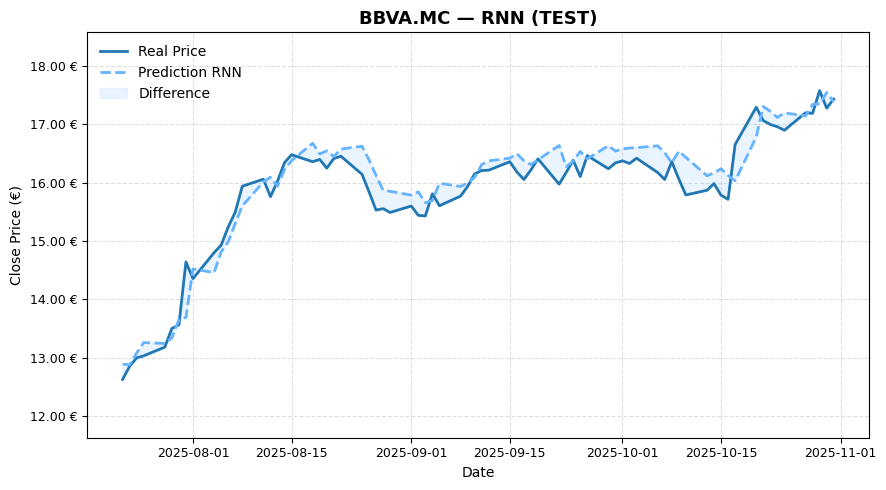

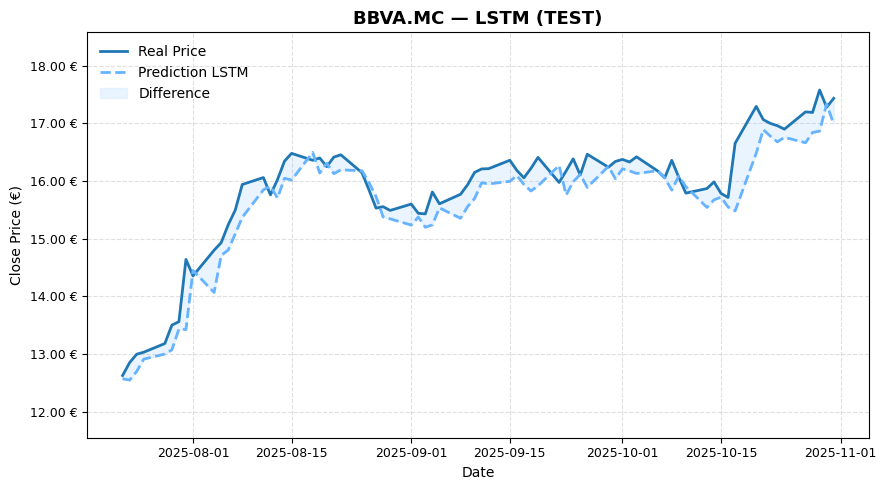

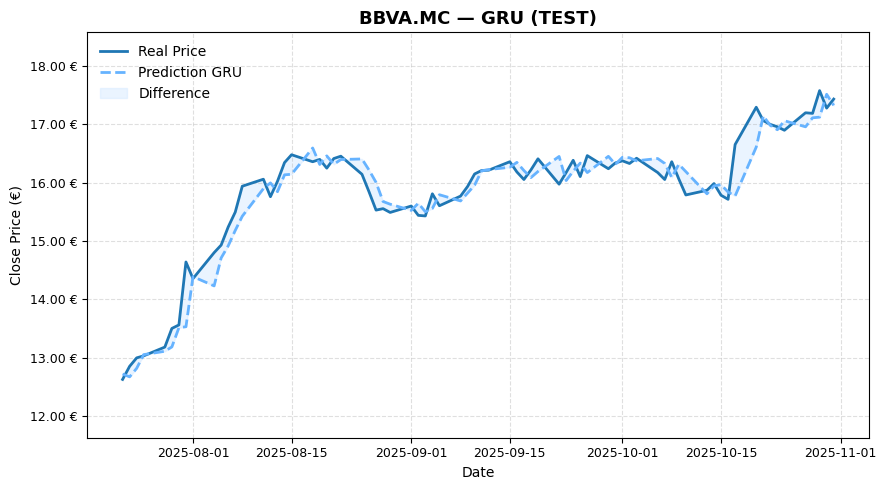

In [48]:
plot_error_fill(dates_test, y_test_real, yhat_rnn_real,  model_label="RNN")
plot_error_fill(dates_test, y_test_real, yhat_lstm_real, model_label="LSTM")
plot_error_fill(dates_test, y_test_real, yhat_gru_real,  model_label="GRU")

## **Comparativa visual entre RNN, LSTM y GRU**

**Objetivo:**
Comparar en una misma figura el comportamiento de los tres modelos.

**Descripción:**
Se construye un gráfico conjunto con las predicciones de RNN, LSTM y GRU superpuestas frente a los valores reales.
Este resumen visual facilita identificar cuál modelo logra mayor fidelidad con el movimiento real del precio, especialmente en los últimos tramos del test.

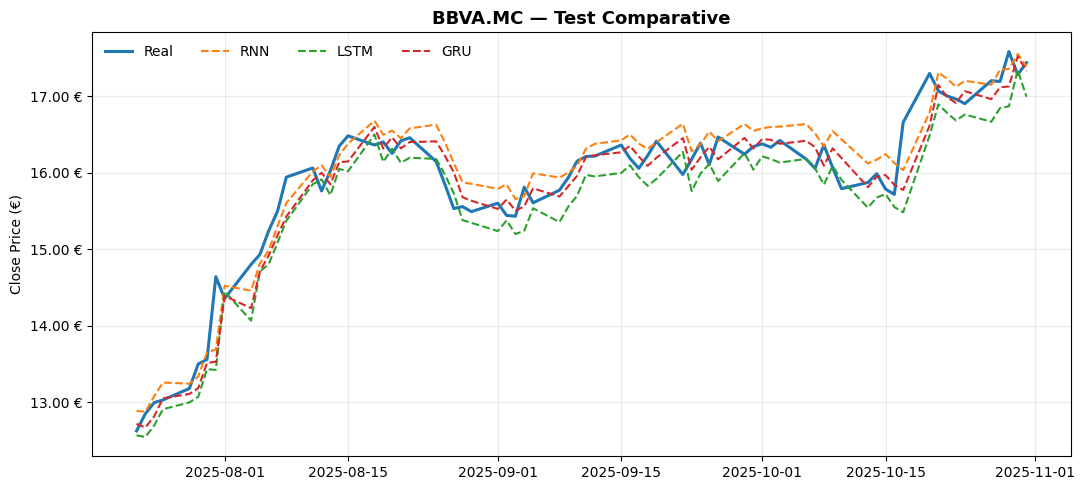

In [49]:
fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(dates_test, y_test_real,    label="Real", linewidth=2.2)
ax.plot(dates_test, yhat_rnn_real,  label="RNN",  linestyle="--")
ax.plot(dates_test, yhat_lstm_real, label="LSTM", linestyle="--")
ax.plot(dates_test, yhat_gru_real,  label="GRU",  linestyle="--")
ax.set_title(f"{SYMBOL} — Test Comparative", fontsize=13, fontweight="bold")
ax.set_ylabel("Close Price (€)")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.2f} €"))
ax.legend(frameon=False, ncol=4)
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

## **Predicciones en test y pronóstico futuro**
Consolidar y guardar las predicciones de test de cada modelo (RNN, LSTM, GRU). Generar un pronóstico multi-paso a futuro (recursivo) a partir de la última ventana disponible.

In [50]:
# Ejecutar forecast para los tres
FORECAST_STEPS = 3

In [51]:
def do_forecast(model, last_block_scaled_df, steps, feature_cols, target_col):
    @torch.no_grad()
    def recursive_forecast(model, last_block_scaled_df, steps, feature_cols, target_col):
        window_mat = last_block_scaled_df[feature_cols].values.astype(np.float32)
        preds_scaled = []
        # If the target column is among features, get its index
        tgt_idx = feature_cols.index(target_col) if target_col in feature_cols else None

        for _ in range(steps):
            x_t = torch.tensor(window_mat[None, :, :], dtype=torch.float32).to(DEVICE)
            yhat_s = model(x_t).cpu().numpy().reshape(-1)[0]
            preds_scaled.append(yhat_s)

            # Create next window
            next_feat = window_mat[-1, :].copy()
            if tgt_idx is not None:
                next_feat[tgt_idx] = yhat_s
            window_mat = np.vstack([window_mat[1:], next_feat])

        return np.array(preds_scaled).reshape(-1, 1)

    scaled = recursive_forecast(model, last_window_block, FORECAST_STEPS, features, TARGET_COL)
    real = scaler_y.inverse_transform(scaled).ravel()
    return real

# Extract last window from full scaled data
full_scaled = pd.concat([train_scaled, test_scaled]).sort_index()
last_window_block = full_scaled.iloc[-WINDOW_SIZE:].copy()

In [52]:
f_rnn  = do_forecast(rnn_model,  last_window_block, FORECAST_STEPS, features, TARGET_COL)
f_lstm = do_forecast(lstm_model, last_window_block, FORECAST_STEPS, features, TARGET_COL)
f_gru  = do_forecast(gru_model,  last_window_block, FORECAST_STEPS, features, TARGET_COL)

# Fechas futuras hábiles
last_date = df.index.max()
future_dates = pd.date_range(start=last_date + pd.tseries.offsets.BDay(1),
                             periods=FORECAST_STEPS, freq="B")

# Números
print("Future Predictions:")
for d, r, l, g in zip(future_dates, f_rnn, f_lstm, f_gru):
    print(f"{d.date()} → RNN: {r:.2f} € | LSTM: {l:.2f} € | GRU: {g:.2f} €")

Future Predictions:
2025-11-03 → RNN: 17.52 € | LSTM: 17.06 € | GRU: 17.31 €
2025-11-04 → RNN: 17.72 € | LSTM: 17.15 € | GRU: 17.42 €
2025-11-05 → RNN: 17.72 € | LSTM: 17.12 € | GRU: 17.46 €


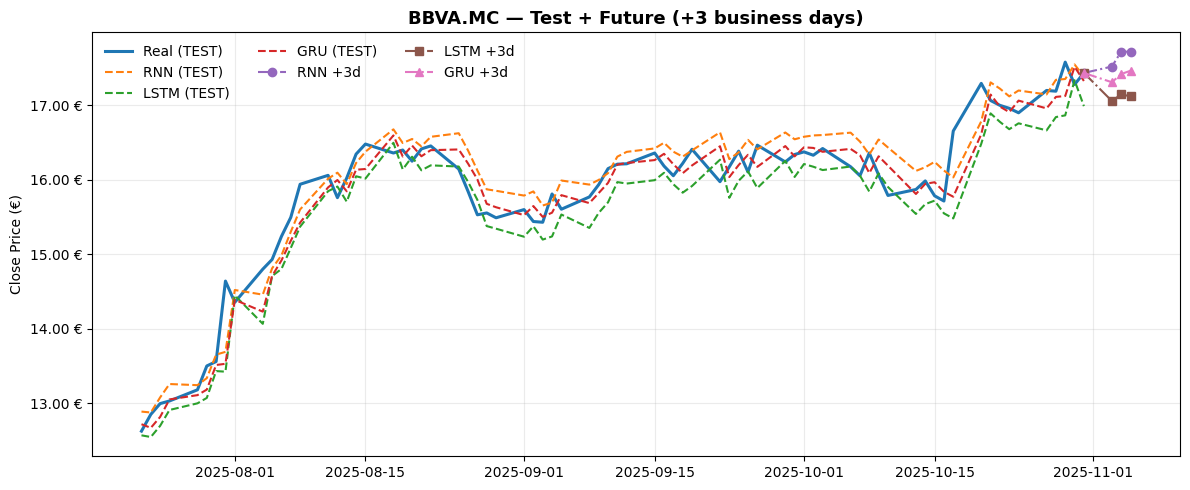

In [53]:
# Gráfico: añadimos puntos futuros a tu comparativa de test
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dates_test, y_test_real,    label="Real (TEST)", linewidth=2.2)
ax.plot(dates_test, yhat_rnn_real,  label="RNN (TEST)",  linestyle="--")
ax.plot(dates_test, yhat_lstm_real, label="LSTM (TEST)", linestyle="--")
ax.plot(dates_test, yhat_gru_real,  label="GRU (TEST)",  linestyle="--")

ax.plot([dates_test[-1]] + list(future_dates), [y_test_real[-1]] + list(f_rnn),  marker="o", linestyle="-.", label=f"RNN +{FORECAST_STEPS}d")
ax.plot([dates_test[-1]] + list(future_dates), [y_test_real[-1]] + list(f_lstm), marker="s", linestyle="-.", label=f"LSTM +{FORECAST_STEPS}d")
ax.plot([dates_test[-1]] + list(future_dates), [y_test_real[-1]] + list(f_gru),  marker="^", linestyle="-.", label=f"GRU +{FORECAST_STEPS}d")

ax.set_title(f"{SYMBOL} — Test + Future (+{FORECAST_STEPS} business days)", fontsize=13, fontweight="bold")
ax.set_ylabel("Close Price (€)")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.2f} €"))
ax.legend(frameon=False, ncol=3)
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

In [54]:
def plot_forecast_extended(
    model_name: str,
    dates_test,
    y_test_real,
    yhat_real,
    future_dates,
    future_preds,
    forecast_steps: int,
    color_real="#003366",     # azul oscuro
    color_future="#00B4D8",   # azul claro
    symbol="BBVA.MC",
    conf_int=0.01,            # ±1% por defecto
    start_date="2025-10-01"
):
    '''
    Graph extended forecast with test data and future predictions including confidence intervals.
    Arguments:
        - model_name: str, name of the model (e.g., "LSTM")
        - dates_test: array-like of test dates
        - y_test_real: array-like of real test values (€)
        - yhat_real: array-like of predicted test values (€)
        - future_dates: array-like of future forecast dates
        - future_preds: array-like of future forecast predictions (€)
        - forecast_steps: int, number of forecast steps
        - color_real: str, color for real data
        - color_future: str, color for future forecast
        - symbol: str, stock symbol
        - conf_int: float, confidence interval percentage (e.g., 0.01 for ±1%)
        - start_date: str, date from which to start plotting (YYYY-MM-DD)
    Returns:
        - None
    '''
    dt_test = pd.to_datetime(pd.Series(dates_test), errors="coerce").dt.tz_localize(None)
    dt_future = pd.to_datetime(pd.Series(future_dates), errors="coerce").dt.tz_localize(None)

    y_test_real = np.asarray(y_test_real, dtype=float).ravel()
    yhat_real   = np.asarray(yhat_real,   dtype=float).ravel()
    future_preds = np.asarray(future_preds, dtype=float).ravel()

    mask_valid = dt_test.notna() # Drop invalid dates
    dt_test = dt_test[mask_valid]
    y_test_real = y_test_real[mask_valid.values]
    if len(dt_test) == 0:
        raise ValueError("Dates in test set are all invalid after conversion.")

    # Strict cut from start_date
    start_ts = pd.to_datetime(start_date)
    mask_cut = dt_test >= start_ts
    if not mask_cut.any():
        # If no dates after start_date, take last 30 points
        mask_cut = pd.Series([False]*len(dt_test))
        mask_cut.iloc[-min(30, len(dt_test)):] = True

    dt_test_cut = dt_test[mask_cut]
    y_test_cut  = y_test_real[mask_cut.values]

    # Forecast future dates: drop NaT
    dt_future = dt_future[dt_future.notna()]
    if len(dt_future) != len(future_preds):
        # Adjust lengths if mismatch
        L = min(len(dt_future), len(future_preds))
        dt_future = dt_future.iloc[:L]
        future_preds = future_preds[:L]

    # Bands for forecast (±conf_int %)
    f_lower = future_preds * (1.0 - conf_int)
    f_upper = future_preds * (1.0 + conf_int)

    # Full series for forecast line (including last real point)
    last_real_date = dt_test.iloc[-1]
    last_real_val  = y_test_real[-1]
    full_dates = pd.concat([pd.Series([last_real_date]), dt_future], ignore_index=True)
    full_preds = np.concatenate([[last_real_val], future_preds])

    # Plotting
    fig, ax = plt.subplots(figsize=(11, 5))
    ax.plot(dt_test_cut, y_test_cut, label="Precio real", color=color_real, linewidth=2.5)
    ax.plot(full_dates, full_preds, color=color_future, marker="o",
            linestyle="-.", linewidth=2.2, label=f"Pronóstico +{forecast_steps}d")
    if len(dt_future) > 0: # Only plot intervals if we have future predictions
        ax.errorbar(
            dt_future, future_preds,
            yerr=[future_preds - f_lower, f_upper - future_preds],
            fmt="none", ecolor=color_future, elinewidth=1.5, capsize=4, alpha=0.9,
            label=f"Intervalo ±{int(conf_int*100)}%"
        )
        ax.fill_between(dt_future, f_lower, f_upper, color=color_future, alpha=0.10)
        ax.axvspan(last_real_date, dt_future.iloc[-1], color=color_future, alpha=0.05)


    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_color("#444444")
        ax.spines[spine].set_linewidth(1.1)

    # Secure y-axis limits
    y_candidates = [y_test_cut]
    if len(future_preds) > 0:
        y_candidates += [future_preds, f_lower, f_upper, np.array([last_real_val])]
    y_min = np.min([arr.min() for arr in y_candidates]) - 0.5
    y_max = np.max([arr.max() for arr in y_candidates]) + 0.5
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.2f} €"))
    ax.tick_params(axis="x", labelsize=9, colors="#444444")
    ax.tick_params(axis="y", labelsize=9, colors="#444444")

    ax.set_title(
        f"{symbol} — {model_name}: Test + Future (+{forecast_steps} business days)",
        fontsize=13, fontweight="bold", pad=12, color="black"
    )
    ax.set_xlabel("Date", fontsize=10, color="#444444")
    ax.set_ylabel("Close Price (€)", fontsize=11, color="#444444")
    ax.legend(frameon=False, fontsize=10, loc="upper left")
    ax.grid(alpha=0.15, linestyle="--")

    plt.tight_layout(pad=1.0)
    plt.show()

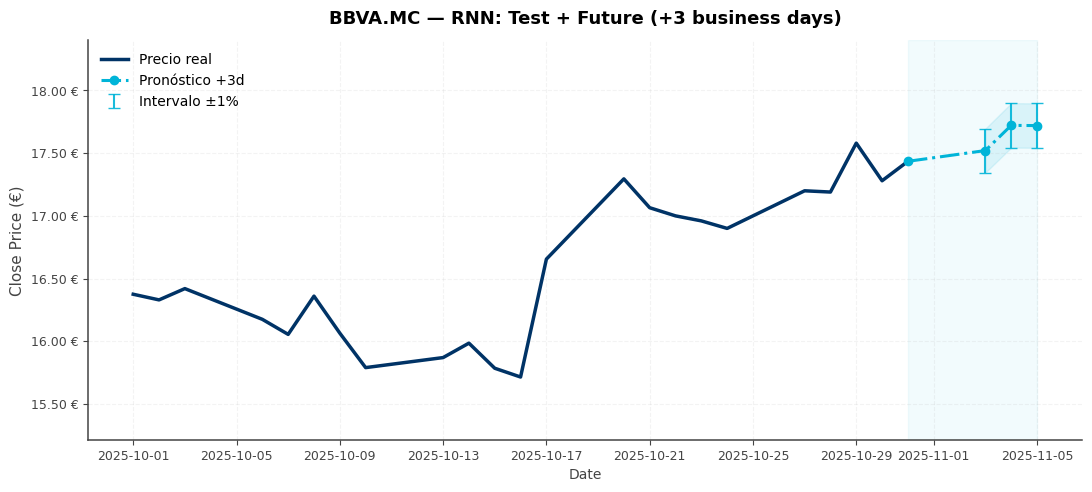

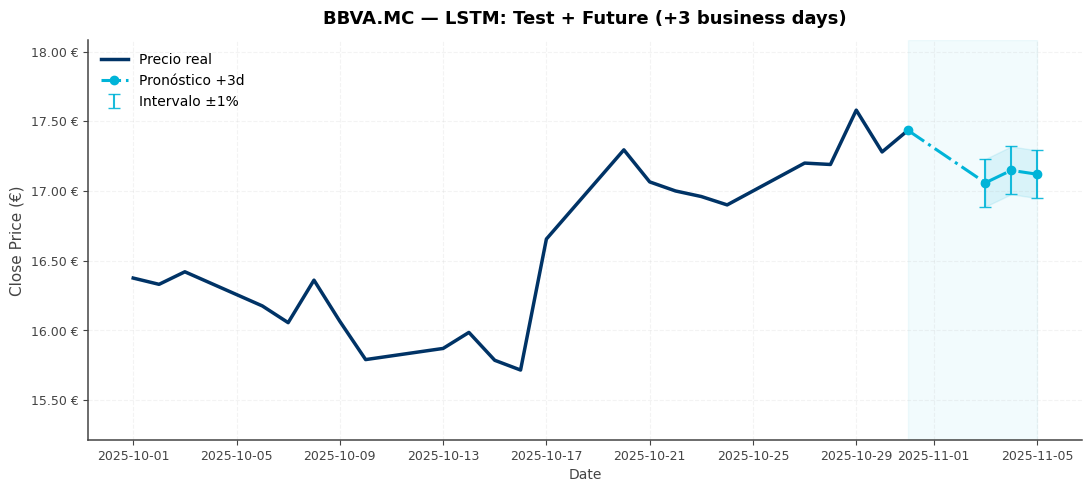

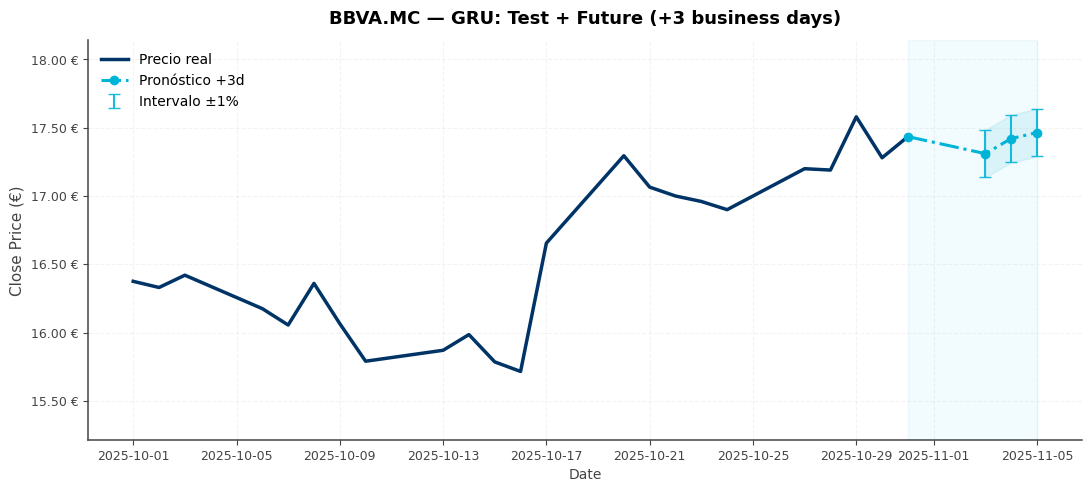

In [55]:
plot_forecast_extended(
    model_name="RNN",
    dates_test=dates_test,
    y_test_real=y_test_real,
    yhat_real=yhat_rnn_real,
    future_dates=future_dates,
    future_preds=f_rnn,
    forecast_steps=FORECAST_STEPS,
    symbol=SYMBOL,
    conf_int=0.01,
)

plot_forecast_extended(
    model_name="LSTM",
    dates_test=dates_test,
    y_test_real=y_test_real,
    yhat_real=yhat_lstm_real,
    future_dates=future_dates,
    future_preds=f_lstm,
    forecast_steps=FORECAST_STEPS,
    symbol=SYMBOL,
    conf_int=0.01,
)

plot_forecast_extended(
    model_name="GRU",
    dates_test=dates_test,
    y_test_real=y_test_real,
    yhat_real=yhat_gru_real,
    future_dates=future_dates,
    future_preds=f_gru,
    forecast_steps=FORECAST_STEPS,
    symbol=SYMBOL,
    conf_int=0.01,
)

## **Guardado de artefactos**

**Objetivo:**
Almacenar los resultados y productos del experimento para futuras referencias o despliegue.

**Descripción:**
Se guardan los **checkpoints** de cada modelo (`.pt`), las **métricas** en formato JSON, las **predicciones** en CSV y la **figura comparativa** final.
De este modo, se asegura la trazabilidad completa del experimento y se facilita la reutilización posterior de los modelos entrenados o de los resultados para análisis comparativos.

In [56]:
REPORTS_DIR = Path("reports")
BUNDLE_ROOT = REPORTS_DIR / "app_bundle" / SYMBOL
timestamp   = datetime.now().strftime("%Y%m%d_%H%M%S")
bundle_dir  = BUNDLE_ROOT / f"{SYMBOL.lower().replace('.mc', '')}_{timestamp}"
(bundle_dir / "models").mkdir(parents=True, exist_ok=True)
(bundle_dir / "scalers").mkdir(parents=True, exist_ok=True)
(bundle_dir / "meta").mkdir(parents=True, exist_ok=True)
(bundle_dir / "data").mkdir(parents=True, exist_ok=True)
(bundle_dir / "figures").mkdir(parents=True, exist_ok=True)
print(f"Bundle directory created at: {bundle_dir}")

Bundle directory created at: reports\app_bundle\BBVA.MC\bbva_20251112_041710


In [57]:
# Save models
torch.save(rnn_model.state_dict(),  bundle_dir / "models" / f"{SYMBOL}_rnn.pt")
torch.save(lstm_model.state_dict(), bundle_dir / "models" / f"{SYMBOL}_lstm.pt")
torch.save(gru_model.state_dict(),  bundle_dir / "models" / f"{SYMBOL}_gru.pt")

In [58]:
# Save scalers
joblib.dump(scaler_X, bundle_dir / "scalers" / f"scaler_X_{SYMBOL}.joblib")
joblib.dump(scaler_y, bundle_dir / "scalers" / f"scaler_y_{SYMBOL}.joblib")

['reports\\app_bundle\\BBVA.MC\\bbva_20251112_041710\\scalers\\scaler_y_BBVA.MC.joblib']

In [59]:
# Save sample data (last WINDOW_SIZE rows for inference)
meta = {
    "symbol": SYMBOL,
    "target_col": str(TARGET_COL),
    "features": list(map(str, features)),
    "window_size": int(WINDOW_SIZE),
    "hyperparams": {
        "hidden_size": int(HIDDEN_SIZE),
        "num_layers": int(NUM_LAYERS),
        "dropout": float(DROPOUT),
        "learning_rate": float(LR),
        "epochs": int(EPOCHS),
        "batch_size": int(BATCH_SIZE) if "BATCH_SIZE" in globals() else None,
        "device": str(DEVICE),
    },
    "split": {
        "train_start": str(train.index.min().date()) if "train" in globals() else None,
        "train_end":   str(train.index.max().date()) if "train" in globals() else None,
        "test_start":  str(test.index.min().date())  if "test"  in globals() else None,
        "test_end":    str(test.index.max().date())  if "test"  in globals() else None,
    },
    "created_at": timestamp,
    "app_notes": "Bundle para inferencia: cargar scalers, recrear ventana de tamaño 'window_size' con 'features', usar el modelo deseado y desescalar con scaler_y."
}
with open(bundle_dir / "meta" / "config.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

In [60]:
# Data for the app
if "metrics_df" in globals():
    metrics_df.to_csv(bundle_dir / "data" / f"{SYMBOL}_metrics_test.csv", index=True)
    with open(bundle_dir / "data" / f"{SYMBOL}_metrics_test.json", "w", encoding="utf-8") as f:
        json.dump(metrics_df.to_dict(orient="index"), f, ensure_ascii=False, indent=2)

if all(k in globals() for k in ["dates_test", "y_test_real", "yhat_rnn_real", "yhat_lstm_real", "yhat_gru_real"]):
    preds_test_df = pd.DataFrame({
        "Date": pd.to_datetime(dates_test),
        "y_real":       np.asarray(y_test_real).ravel(),
        "yhat_rnn":     np.asarray(yhat_rnn_real).ravel(),
        "yhat_lstm":    np.asarray(yhat_lstm_real).ravel(),
        "yhat_gru":     np.asarray(yhat_gru_real).ravel(),
    })
    preds_test_df.to_csv(bundle_dir / "data" / f"{SYMBOL}_test_predictions.csv", index=False)

if all(k in globals() for k in ["future_dates", "f_rnn", "f_lstm", "f_gru"]):
    forecast_df = pd.DataFrame({
        "Date": pd.to_datetime(future_dates),
        "forecast_rnn":  np.asarray(f_rnn).ravel(),
        "forecast_lstm": np.asarray(f_lstm).ravel(),
        "forecast_gru":  np.asarray(f_gru).ravel(),
    })
    forecast_df.to_csv(bundle_dir / "data" / f"{SYMBOL}_forecast_next.csv", index=False)

df_1.to_csv(bundle_dir / "data" / f"{SYMBOL}_full_data.csv", index=True)

In [61]:
manifest = {
    "bundle_path": str(bundle_dir.resolve()),
    "artifacts": {
        "models": [f"models/{SYMBOL}_rnn.pt", f"models/{SYMBOL}_lstm.pt", f"models/{SYMBOL}_gru.pt"],
        "scalers": [f"scalers/scaler_X_{SYMBOL}.joblib", f"scalers/scaler_y_{SYMBOL}.joblib"],
        "meta": ["meta/config.json"],
    },
    "created_at": timestamp
}
with open(bundle_dir / "manifest.json", "w", encoding="utf-8") as f:
    json.dump(manifest, f, ensure_ascii=False, indent=2)

print("Bundle generated at:")
print("   ", bundle_dir.resolve())
print("   Content:")
for k, v in manifest["artifacts"].items():
    print(f"   - {k}: {v}")

Bundle generated at:
    C:\Users\mgonzgarc\Documents\GitHub\ibex-banks-rnn-forecast\reports\app_bundle\BBVA.MC\bbva_20251112_041710
   Content:
   - models: ['models/BBVA.MC_rnn.pt', 'models/BBVA.MC_lstm.pt', 'models/BBVA.MC_gru.pt']
   - scalers: ['scalers/scaler_X_BBVA.MC.joblib', 'scalers/scaler_y_BBVA.MC.joblib']
   - meta: ['meta/config.json']
